# Aim
Repeat earlier analyses like in step4 but:
* without ARP clade
* without spuriouos CDC5 sequence

+ Add arabidopsis mybs to annotate their subfamily as in J&R
+ Annotate the tree with RNA seq data for Azolla filiculoides
+ Add more _Azolla filiculoides_ MYB sequences

All sequences are linear already, so I can start composing the fasta file and aligning right away.

In [65]:
for i in data/*_sequences.fasta
do  inseq=$(echo $i | cut -d '/' -f 2 | cut -d '.' -f 1)
    if   [ ! -f data/"$inseq"_linear.fasta ] 
    then cat data/$inseq.fasta \
         | awk '/^>/ {printf("%s%s\n",(N>0?"\n":""),$0);N++;next;} {printf("%s",$0);} END {printf("\n");}' \
         > data/"$inseq"_linear.fasta
    fi
done

In [67]:
cat data/CDC5-outgroup_sequences_linear.fasta \
    data/I_sequences_linear.fasta    \
    data/II_sequences_linear.fasta   \
    data/III_sequences_linear.fasta  \
    data/IV_sequences_linear.fasta   \
    data/V_sequences_linear.fasta    \
    data/VI_sequences_linear.fasta   \
    data/VII_sequences_linear.fasta  \
    data/VIII_sequences_linear.fasta \
    data/Azfi-mybs-subfamVI-suspects_linear.fasta \
    data/R1R2R3_sequences_linear.fasta \
    data/arabidopsis-myb_sequences_linear.fasta \
    data/Azfi-v1-MYB_sequences_linear.fasta \
    > data/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear.fasta
    

In [68]:
inseq=combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear

In [69]:
rm ./data/alignments_raw/"$inseq"_aligned-mafft-einsi.*

In [70]:
conda activate phylogenetics
if    [ ! -d ./data/alignments_raw/ ]
then  mkdir  ./data/alignments_raw
fi
for   i in data/combi*sequences_linear.fasta
do    if    [ ! -f "./data/alignments_raw/$inseq"_aligned-mafft-einsi.fasta ]
      then  echo "aligning $inseq"
            einsi --thread $(nproc) data/$inseq.fasta > ./data/alignments_raw/"$inseq"_aligned-mafft-einsi.fasta \
                                                      2> ./data/alignments_raw/"$inseq"_aligned-mafft-einsi.log
      fi
done
conda deactivate

(phylogenetics) (phylogenetics) aligning combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear
(phylogenetics) 

In [71]:
conda activate jalview
for   i in data/alignments_raw/*.fasta
do    prefix=$(echo $i | sed 's/\.fasta//')
      if    [ ! -f $prefix.png ]
      then  jalview -nodisplay \
                    -open $prefix.fasta \
                    -colour CLUSTAL \
                    -png  $prefix.png > /dev/null 2> /dev/null
      fi
done
conda deactivate

(jalview) (jalview) 

The linsi alignment looks like this:
![](data/alignments_raw/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi.png)

That looks quite a bit more sparse than the einsi alignments I have seen before, likely as a consequence of adding all these recent arabidopsis sequences.

In [60]:
rm  data/alignments_trimmed/"$inseq"*

In [61]:
conda activate phylogenetics
if    [ ! -d data/alignments_trimmed ]
then  mkdir  data/alignments_trimmed 
fi

gt=( 4 5 6 )

# define appendix only once here:
for g in ${gt[@]}
do  trimappendix=trim-gt"$g"
    for a in "data/alignments_raw/$inseq"_aligned*.fasta
    do  appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
        if    [ ! -f "$appendix"_"$trimappendix".fasta ]
        then  echo "trimming alignment $a with gap threshold $g"
              sed -i 's/ /_/g' $a
              trimal -in $a   \
                     -out data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta \
                     -gt ."$g" \
                     -htmlout data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".html &
        fi
    done
done
wait
conda deactivate

(phylogenetics) (phylogenetics) (phylogenetics) (phylogenetics) (phylogenetics) (phylogenetics) trimming alignment data/alignments_raw/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi.fasta with gap threshold 4
[1] 1098837
trimming alignment data/alignments_raw/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi.fasta with gap threshold 5
[2] 1098844
trimming alignment data/alignments_raw/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi.fasta with gap threshold 6
[3] 1098851
(phylogenetics) [1]   Done                    trimal -in $a -out data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta -gt ."$g" -htmlout data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".html
[2]-  Done                    trimal -in $a -out data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta -gt ."$g" -htmlout data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".html
[3]+  Done                    trimal -in $

In [62]:
conda activate jalview
for   i in data/alignments_trimmed/*.fasta
do    prefix=$(echo $i | sed 's/\.fasta//')
      if    [ ! -f $prefix.png ]
      then  jalview -nodisplay \
                    -open $prefix.fasta \
                    -colour CLUSTAL \
                    -png  $prefix.png > /dev/null 2> /dev/null &
      fi
done
wait
conda deactivate

(jalview) [1] 1098864
[2] 1098869
[3] 1098881
(jalview) [1]   Done                    jalview -nodisplay -open $prefix.fasta -colour CLUSTAL -png $prefix.png > /dev/null 2> /dev/null
[3]+  Done                    jalview -nodisplay -open $prefix.fasta -colour CLUSTAL -png $prefix.png > /dev/null 2> /dev/null
[2]+  Done                    jalview -nodisplay -open $prefix.fasta -colour CLUSTAL -png $prefix.png > /dev/null 2> /dev/null
(jalview) 

### 60%
![einsi 6 trimmed](data/alignments_trimmed/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt6.png)

### 50%
![50](data/alignments_trimmed/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt5.png)

### 40%
![](data/alignments_trimmed/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt4.png)

~~Based on past experience, I'm inclined to got with the 50% collumn content alignment, it looks most like the alignments I have used in step 4.~~

~~I'm having strong doubts about the last two sequences in the MSA, I'll proceed for now, but likely reitterate over this notebook again to take them out.~~
These squences were removed from the dataset and the alignments were remade.

In [ ]:
conda activate phylogenetics
for a in data/alignments_trimmed/"$inseq"_aligned*gt*.fasta
do  #iqpendix='iqtree-b100'
    iqpendix='iqtree-bb2000-alrt2000'

    file_appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
    
    if   [ ! -d    analyses/"$inseq"_trees/"$file_appendix" ]
    then echo "Making a directory $file_appendix to store trees (name based on alignment filename)"
         mkdir -p  analyses/"$inseq"_trees/"$file_appendix" 
    fi

    iqprefix=analyses/"$inseq"_trees/"$file_appendix"/"$inseq"_"$file_appendix"_"$iqpendix"
    if   [ ! -f "$iqprefix".treefile ]
    then echo "making a tree of file $a"
         nice iqtree -s $a \
                     -m MFP \
                     -bb 2000 -alrt 2000 \
                     -nt AUTO \
                     -ntmax $(nproc)  \
                     -pre  "$iqprefix" \
                     2>   "$iqprefix".stderr \
                      >    "$iqprefix".stdout
    #cat "$iqprefix".log | mail -s "IQtree_run $a" laura
    fi
done
conda deactivate

(phylogenetics) Making a directory aligned-mafft-einsi_trim-gt4 to store trees (name based on alignment filename)
making a tree of file data/alignments_trimmed/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt4.fasta
Making a directory aligned-mafft-einsi_trim-gt5 to store trees (name based on alignment filename)
making a tree of file data/alignments_trimmed/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt5.fasta
Making a directory aligned-mafft-einsi_trim-gt6 to store trees (name based on alignment filename)
making a tree of file data/alignments_trimmed/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt6.fasta


I accidentally ran trees of all three trimmings, so let's have a look anyway.

In [51]:
cd ./analyses/"$inseq"_trees/
grep 'Best-fit model' */*.log
cd ../../

(phylogenetics) aligned-mafft-einsi_trim-gt4/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt4_iqtree-b200.log:Best-fit model: VT+F+R5 chosen according to BIC
aligned-mafft-einsi_trim-gt4/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt4_iqtree-bb2000-alrt2000.log:Best-fit model: LG+F+R6 chosen according to BIC
aligned-mafft-einsi_trim-gt5/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt5_iqtree-bb2000-alrt2000.log:Best-fit model: LG+F+R5 chosen according to BIC
aligned-mafft-einsi_trim-gt6/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt6_iqtree-bb2000-alrt2000.log:Best-fit model: LG+F+R5 chosen according to BIC
(phylogenetics) (phylogenetics) 

: 1

In [50]:
conda activate phylogenetics
for a in data/alignments_trimmed/"$inseq"_aligned*gt*.fasta
do  iqpendix='iqtree-b200'
    #iqpendix='iqtree-bb2000-alrt2000'

    file_appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
    
    if   [ ! -d    analyses/"$inseq"_trees/"$file_appendix" ]
    then echo "Making a directory $file_appendix to store trees (name based on alignment filename)"
         mkdir -p  analyses/"$inseq"_trees/"$file_appendix" 
    fi

    iqprefix=analyses/"$inseq"_trees/"$file_appendix"/"$inseq"_"$file_appendix"_"$iqpendix"
    if   [ ! -f "$iqprefix".treefile ]
    then echo "making a tree of file $a"
         nice iqtree -s $a  \
                     -m MFP \
                     -b 200 \
                     -nt AUTO \
                     -ntmax $(nproc)  \
                     -pre  "$iqprefix" \
                     2>   "$iqprefix".stderr \
                      >    "$iqprefix".stdout
    #cat "$iqprefix".log | mail -s "IQtree_run $a" laura
    fi
done
conda deactivate

(phylogenetics) making a tree of file data/alignments_trimmed/combi-I-to-VIII-Azfi-Arabidopsis_sequences_linear_aligned-mafft-einsi_trim-gt4.fasta

(phylogenetics) 

### Intermediate conclusion

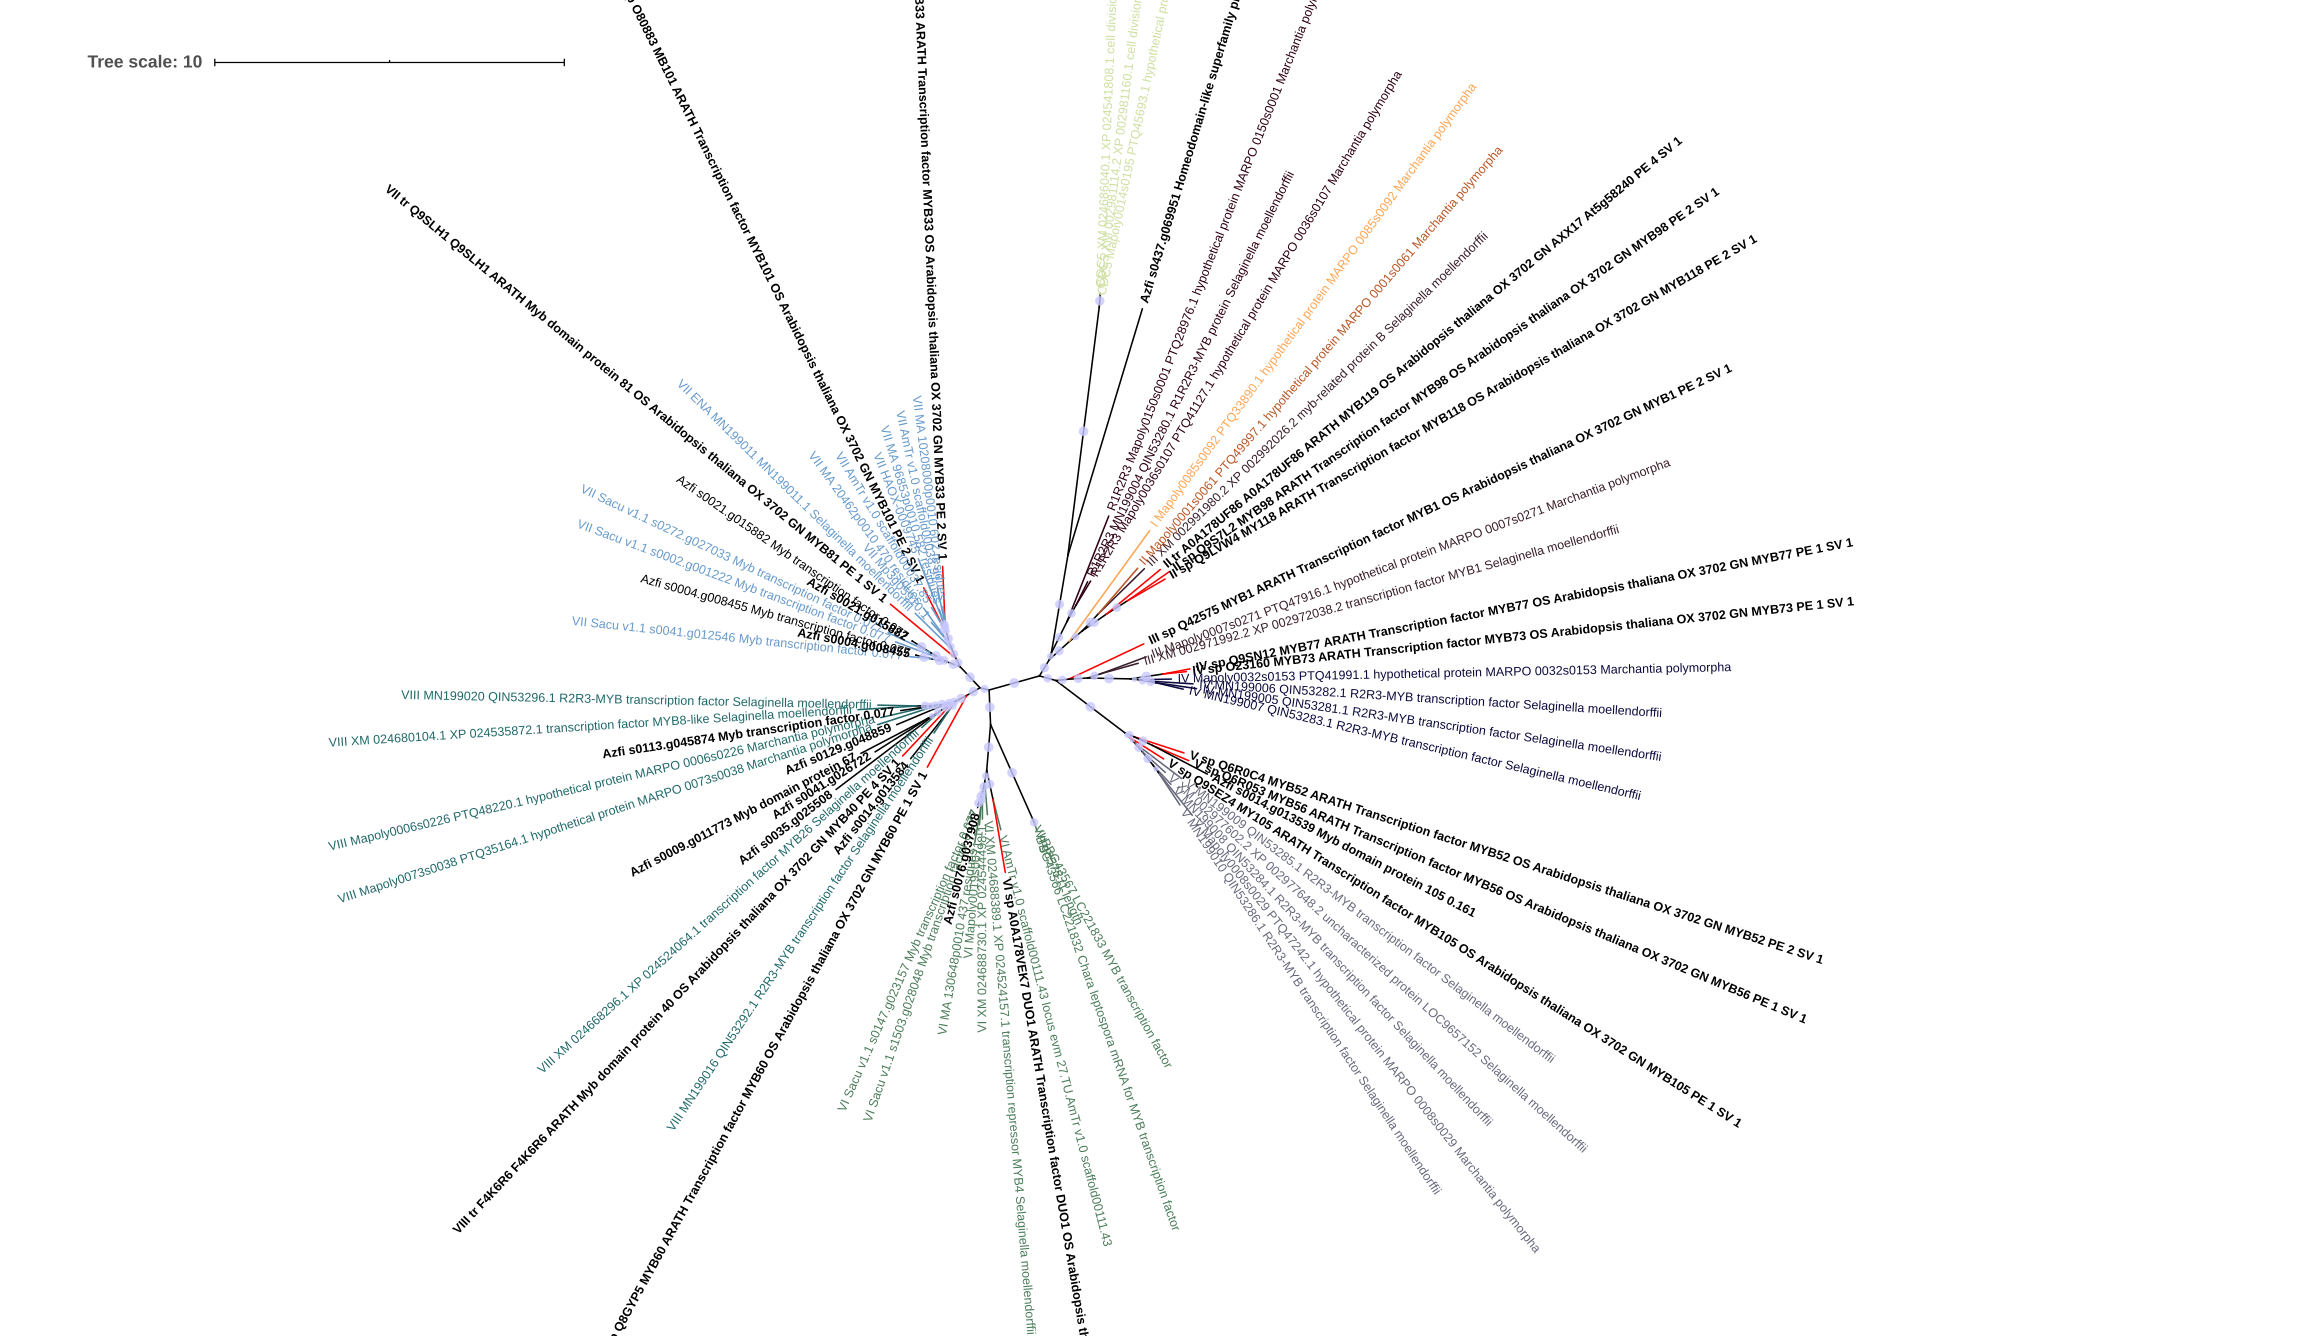

Most sequences end up in a nice clade, but indeed one sequence that behaved oddly in the alignment already is placed in the outgroup here.
This placement seems to be consistent and well supported.
I will remove this sequence from the starting dataset, and run the whole notebook again.